# Year 2023 Day 03

[--- Day 3: Gear Ratios ---](https://adventofcode.com/2023/day/3)


WIP!

## Motive

Here, the [Text Mark](https://observablehq.com/plot/marks/text) is put in the spotlight.

Also, an attempt is made to refactor the visualization code in order to get a more flexible API. The main idea is to step-up from raw functions with too many keyword arguments to a lazy-builder pattern, creating an open-ended lazy task graph on which it is easy to add other plotting steps. This can be seen as a layer system, to layer marks on top of each other, while being able to reuse a common stack. This comes handy in situation where we want to compose _orthogonally_ multiple marks together. The concrete example in this notebook will be the "neighborhood" visualization, that can be pasted over different initial raster visualizations (like a base map). 

To improve the abstraction, the vocabulary from all cartography APIs could be reused.

## Related puzzles

The Observable Plot visualization library is used.

The [Text Mark](https://observablehq.com/plot/marks/text) is also used in:

- [Notebook 202310](./notebook_problem_202310.html) (_Pipe Maze_) to add values on top of a [Raster Mark](https://observablehq.com/plot/marks/raster)
- [Notebook 202324](./notebook_problem_202324.html) (_Never Tell Me The Odds_) to annotate vectors (the [Link Mark](https://observablehq.com/plot/marks/link)) with a time value


In [1]:
import json
from typing import Literal

import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import Markdown as md
from pyobsplot import Obsplot, Plot

from advent_of_code.common.common import get_example_inputs_file_contents
from advent_of_code.visualization.plotly import (
    ValuedLink,
    build_sankey_figure,
    to_plotly_sankey_input,
)
from advent_of_code.y_2023.problem_202303 import AdventOfCodeProblem202303

In [2]:
op = Obsplot(renderer="jsdom", theme="dark")  # Literal['current','light','dark']

In [3]:
problem = AdventOfCodeProblem202303()
problem

AdventOfCodeProblem202303(year=2023, day=3)

In [4]:
example_input = get_example_inputs_file_contents(2023)["test_problem_202303"][
    "EXAMPLE_INPUT"
]

## With Example Input


In [5]:
from typing import Any
import numpy as np
import xarray as xr
import numpy.typing as npt

In [6]:
parsed_example_input = xr.DataArray(
    problem.parse_text_input(example_input), dims=("row", "col")
)

### Visualization Code


In [7]:
# from advent_of_code.visualization.observable_plot import visualize_puzzle_input_202310


from typing import Callable
from advent_of_code.visualization.observable_plot import ObservablePlotXarrayBuilder


# Based on visualize_puzzle_input_202310
def text_mark_producer(
    xda: xr.DataArray,
    *,
    text_xda: xr.DataArray | None = None,
    width: int,
) -> Callable[[], list[Any]]:
    def callback() -> list[Any]:
        if text_xda is None:
            return []

        df = text_xda.stack(z=("row", "col")).to_pandas()
        data = df.values.tolist()
        rows = [idx[0] + 0.5 for idx in df.index]
        cols = [idx[1] + 0.5 for idx in df.index]
        return [
            Plot.text(  # type:ignore
                data,
                {
                    "text": Plot.identity,  # type: ignore
                    "x": cols,
                    "y": rows,
                    "color": "white",
                    "fontSize": 38 * width / 600 * 13 / xda["col"].size,
                },
            )
        ]

    return callback


def plot_ascii_2d_numpy_array(
    xda: xr.DataArray,
    *,
    obfuscate: bool = True,
    text: bool = True,
    scheme: str = "Tableau10",
    **kwargs: Any,
) -> ObservablePlotXarrayBuilder:
    if xda.dtype == np.uint8:
        simplified_xda = xda.where(
            ~xda.isin(list(range(ord("1"), ord("9") + 1))), ord("N")
        )
    else:
        simplified_xda = xda

    text_xda = None

    if text:
        if obfuscate:
            text_xda = simplified_xda
        else:
            text_xda = xda

        # Convert ASCII uint8 to str (S1) then str (for it to be serializable)
        text_xda = text_xda.copy(data=text_xda.values.view("S1").astype("str"))

    if xda.dtype == np.uint8:
        simplified_xda = simplified_xda.copy(
            data=simplified_xda.values.view("S1").astype("str")
        )
    kwargs = {
        **dict(
            margin=0,
            do_convert_ascii_array_to_uint8=False,
            width=300,
            color={"type": "categorical", "scheme": scheme, "legend": True},
        ),
        **kwargs,
    }

    builder = ObservablePlotXarrayBuilder(
        raster_xda=simplified_xda, initial_kwargs=kwargs
    )
    text_callback = text_mark_producer(
        simplified_xda, text_xda=text_xda, width=kwargs["width"]
    )
    builder.append(text_callback)
    return builder




In [8]:
input_builder = plot_ascii_2d_numpy_array(
    parsed_example_input, obfuscate=False, text=True
)
input_builder.plot()

Symbols are defined as being non-numerical and different to the dot character.


In [9]:
def extract_symbols_xda(xda: xr.DataArray) -> xr.DataArray:
    symbols = ((xda != ord(".")) * 1) & ~xda.isin(
        list(range(ord("1"), ord("9") + 1))
    )
    return symbols


symbols = extract_symbols_xda(parsed_example_input)

In [10]:
symbols_builder = plot_ascii_2d_numpy_array(
    symbols, obfuscate=False, text=False, scheme="viridis"
)
# The copy do not work as the text mark is still generated from the initial builder creation
# symbols_builder = input_builder.copy(raster_xda=symbols, text=False, scheme="viridis")
# symbols_builder.initial_kwargs
symbols_builder.plot()

We are interested in all numbers in the neighborhood of the symbols. The neighborhood is a 3x3 box with the symbol in its center.


In [11]:
df = symbols.stack(y=("row", "col")).to_pandas()
df = df[df == 1]

rows_1 = [idx[0] - 1 for idx in df.index]
rows_2 = [idx[0] + 1 for idx in df.index]
cols_1 = [idx[1] - 1 for idx in df.index]
cols_2 = [idx[1] + 1 for idx in df.index]

x1_target = "x1"
x2_target = "x2"
y1_target = "y1"
y2_target = "y2"

rect_df = pd.DataFrame.from_records(
    {
        x1_target: rows_1,
        x2_target: rows_2,
        y1_target: cols_1,
        y2_target: cols_2,
    }
)

In [12]:
# TODO: in pause because the PlotBuilder would be a better approach than endless keywords.
def create_neighborhood_mark_producer(
    xda: xr.DataArray,
    *,
    color: str = "red",
    stroke_width: int = 2,
) -> Callable[[], list[Any]]:
    def callback() -> list[Any]:
        df = xda.stack(y=("row", "col")).to_pandas()
        df = df[df == 1]

        offset = 0.3
        rows_1 = [idx[0] - (offset + 0.5) for idx in df.index]
        rows_2 = [idx[0] + (offset + 1.5) for idx in df.index]
        cols_1 = [idx[1] - (offset + 0.5) for idx in df.index]
        cols_2 = [idx[1] + (offset + 1.5) for idx in df.index]

        x1_target = "x1"
        x2_target = "x2"
        y1_target = "y1"
        y2_target = "y2"

        rect_df = pd.DataFrame.from_records(
            {
                x1_target: cols_1,
                x2_target: cols_2,
                y1_target: rows_1,
                y2_target: rows_2,
            }
        )
        return [
            Plot.rect(  # type:ignore
                rect_df,
                {
                    x1_target: "x1",
                    y1_target: "y1",
                    x2_target: "x2",
                    y2_target: "y2",
                    "stroke": color,
                    "strokeWidth": stroke_width,
                },
            ),
        ]

    return callback

In [13]:
neighborhood_mark_producer = create_neighborhood_mark_producer(symbols)

In [14]:
symbols_builder.append(neighborhood_mark_producer).plot()

In [15]:
input_builder.append(neighborhood_mark_producer).plot()

In Part 1, the _part numbers_ are all numbers intersecting with the neighboorhood.

In [16]:
from advent_of_code.y_2023.problem_202303 import find_part_numbers

part_numbers = find_part_numbers(parsed_example_input.values)
part_numbers

[467, 35, 633, 617, 592, 755, 664, 598]

In Part 2, we are only interested by gears, represented by the `*`-symbol, if they are adjacent to exactly two _part numbers_.

In [17]:
from advent_of_code.y_2023.problem_202303 import find_part_numbers_and_gears


gear_part_numbers_tuples = find_part_numbers_and_gears(parsed_example_input.values)
gear_part_numbers_tuples

[(467, 35), (755, 598)]

Create the couples of lines materializing the left and right boundaries of the mapping. They will be displayed in white.


Create the single central lines materializing the center of the mapping. They will be displayed in red.


## With Actual Input


In [18]:
parsed_actual_input = xr.DataArray(problem.parse_input_text_file(), dims=("row", "col"))
parsed_actual_input

<xarray.DataArray (row: 142, col: 142)>
array([[46, 46, 46, ..., 46, 46, 46],
       [46, 46, 46, ..., 46, 46, 46],
       [46, 53, 54, ..., 46, 46, 46],
       ...,
       [46, 46, 46, ..., 46, 46, 46],
       [46, 57, 53, ..., 52, 54, 46],
       [46, 46, 46, ..., 46, 46, 46]], dtype=uint8)
Dimensions without coordinates: row, col

In [19]:
plot_width = parsed_actual_input["col"].size * 3


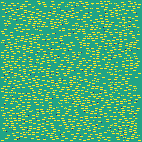

In [20]:
input_builder = plot_ascii_2d_numpy_array(
    parsed_actual_input,
    obfuscate=True,
    text=False,
    width=plot_width,
    scheme="viridis",
)
input_builder.plot()

In [21]:
symbols = extract_symbols_xda(parsed_actual_input)


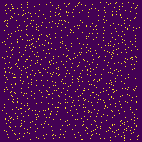

In [22]:
symbols_builder = plot_ascii_2d_numpy_array(
    symbols,
    obfuscate=False,
    text=False,
    width=plot_width,
    scheme="viridis",
)
symbols_builder.plot()

In [23]:
neighborhood_mark_producer = create_neighborhood_mark_producer(symbols)


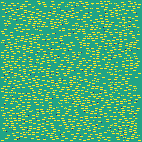

In [24]:
input_builder.append(neighborhood_mark_producer).plot()


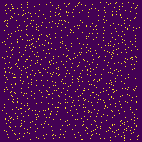

In [25]:
symbols_builder.append(neighborhood_mark_producer).plot()